We will use the lemonade inc data we scraped in the earlier script to create a regression model to predict returns based on features already in the dataset and some new features we will engineer. We will be predicting 6 month forward returns based on historical data.

In [1]:
import pandas as pd

df = pd.read_csv("Data/lmnd_daily_5y.csv", parse_dates=["Date"])
df = df.sort_values("Date").set_index("Date")


df.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2020-12-02,66.830002,66.830002,67.110001,62.310001,65.389999,1059000
2020-12-03,80.349998,80.349998,83.169998,65.919998,66.989998,9344400
2020-12-04,85.040001,85.040001,85.949997,78.029999,82.500000,5463900
2020-12-07,91.720001,91.720001,99.989998,88.019997,90.029999,7528100
2020-12-08,90.599998,90.599998,97.650002,89.349998,97.309998,3844500


In [2]:
# create daily returns colum as a new feature
df["ret_daily"] = df["Adj Close"].pct_change()
df.head()


,Adj Close,Close,High,Low,Open,Volume,ret_daily
Date,,,,,,,
2020-12-02,66.830002,66.830002,67.110001,62.310001,65.389999,1059000,NaN
2020-12-03,80.349998,80.349998,83.169998,65.919998,66.989998,9344400,0.202304
2020-12-04,85.040001,85.040001,85.949997,78.029999,82.500000,5463900,0.058370
2020-12-07,91.720001,91.720001,99.989998,88.019997,90.029999,7528100,0.078551
2020-12-08,90.599998,90.599998,97.650002,89.349998,97.309998,3844500,-0.012211


In [3]:
#6‑month horizon in trading days (approx 252 trading days in a year)
horizon = 21 * 6 # 126 trading days

# what we are doing here is basically for any given day, we want to know what the adjusted close price will be after our horizon (6 months in our case)
df["AdjClose_future"] = df["Adj Close"].shift(-horizon)
# now we can calculate the forward return over the 6 month horizon
df["fwd_6m_ret"] = (df["AdjClose_future"] - df["Adj Close"]) / df["Adj Close"]

In [4]:


# we will drop an rows with NaN values that were created due to pct_change and shift operations
df = df.dropna()
df.head()

# check now many data points we have
print(f"Number of data points after initial feature engineering: {len(df)}")

Number of data points after initial feature engineering: 1127


we are going to create a few more features to help with our prediction task. namely ret_5d_mean, ret_20d_mean, ret_20d_std, range_hl and log_volume

In [5]:
df["ret_5d_mean"]  = df["ret_daily"].rolling(5).mean()
df["ret_20d_mean"] = df["ret_daily"].rolling(20).mean()
df["ret_20d_std"]  = df["ret_daily"].rolling(20).std()
df["range_hl"]     = (df["High"] - df["Low"]) / df["Open"]
import numpy as np
df["log_volume"]   = np.log(df["Volume"])
feature_cols = ["ret_daily","ret_5d_mean","ret_20d_mean",
                "ret_20d_std","range_hl","log_volume"]
df_model = df.dropna()

print(f"Number of data points after all feature engineering: {len(df_model)}")

Number of data points after all feature engineering: 1108


In [6]:
df_model.head()

X = df_model[feature_cols]
y = df_model["fwd_6m_ret"]

We will be splitting the data into training and testing sets based on time. 80% of the data will be used for training and the remaining 20% for testing. This is to ensure that our model is evaluated on future data that it has not seen during training, simulating a real-world scenario.

In [7]:
split_idx = int(len(df_model) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [8]:
# import the scikit-learn library for regression modeling and evaluation metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("RMSE:", rmse)
print("MAE :", mae)


RMSE: 0.806538003528565
MAE : 0.7002361092054153


While these metrics are quite bad we will compare them to a baseline model in the next steps to see if our model is actually learning anything useful and then use a more complex model if needed.

In [9]:

y_mean = y_train.mean()
baseline_pred = np.full_like(y_test, fill_value=y_mean, dtype=float)

baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_mae  = mean_absolute_error(y_test, baseline_pred)

print("Baseline RMSE:", baseline_rmse)
print("Baseline MAE :", baseline_mae)

Baseline RMSE: 0.8119013157224774
Baseline MAE : 0.6999181425493171


We are goint to now retrain on the entire dataset and use this model to predict the next 6 month return for the most recent date in our dataset.

In [10]:
X_all = df_model[feature_cols]
y_all = df_model["fwd_6m_ret"]

linreg_full = LinearRegression()
linreg_full.fit(X_all, y_all)

# last available date we have features for
last_row = X_all.iloc[[-1]]
future_6m_ret_pred = linreg_full.predict(last_row)[0]
print("Predicted 6‑month return from last date:", future_6m_ret_pred)

Predicted 6‑month return from last date: 0.1288392746039156


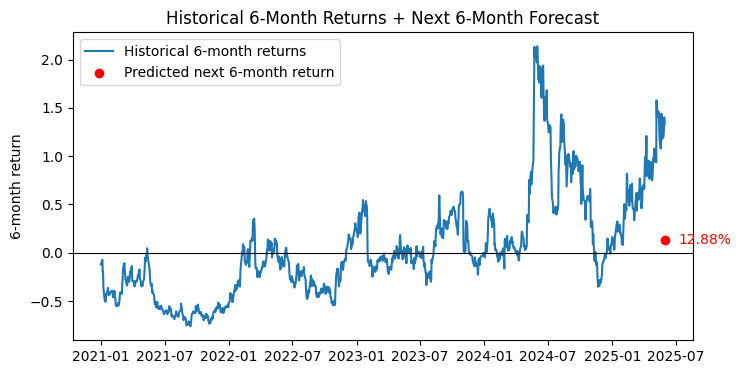

In [16]:
# mark the predicted return on a plot of historical returns
import matplotlib.pyplot as plt
last_date = X_all.index[-1]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(y_all.index, y_all, label="Historical 6‑month returns")
ax.scatter(last_date, future_6m_ret_pred, color="red",
           label="Predicted next 6‑month return", zorder=3)
# label this point with text (use annotate to allow xytext/textcoords)
ax.annotate(f"{future_6m_ret_pred:.2%}",
            xy=(last_date, future_6m_ret_pred),
            xytext=(10, 0), textcoords="offset points",
            va="center", color="red")
ax.axhline(0, color="black", linewidth=0.8)
ax.set_title("Historical 6‑Month Returns + Next 6‑Month Forecast")
ax.set_ylabel("6‑month return")
ax.legend()
plt.show()